In [1]:
# Global variable to run code on colab or locally
COLAB = False

In [2]:
if COLAB:
    !pip install efficientnet_pytorch

In [3]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import zipfile
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torchvision.transforms.functional as TF

In [4]:
print(np.__version__)
print(torch.__version__)

1.24.4
1.10.1+cu111


In [5]:
print(f"Parallel process available: {os.cpu_count()}")

Parallel process available: 8


In [6]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    # about 3 min
    import zipfile

    zip_path = "/content/drive/MyDrive/archive.zip"
    extract_path = "/content/archive_unzipped"

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [8]:
def get_single_hand(image, row):
    if int(row["id"]) <= 5496:
        json_path = "./RHPE/RHPE_Annotations/RHPE_anatomical_ROIs_train.json"
    else:
        json_path = "./RHPE/RHPE_Annotations/RHPE_anatomical_ROIs_val.json"

    with open(json_path, "r") as f:
        data = json.load(f)
    
    image_entry = next(img for img in data["images"] if img["file_name"] == row["filename"])
    image_width = image_entry["width"]
    image_height = image_entry["height"]

    annotation_entry = next(ann for ann in data["annotations"] if ann["image_id"] == image_entry["id"])

    # === Estrai bbox COCO-style ===
    x_min, y_min, w, h = annotation_entry["bbox"]
    x_max = x_min + w
    y_max = y_min + h

    if bool(row["left"]):
        single_hand_image = image[0:int(image_height), 0:int(x_max)]

    else:
        single_hand_image = np.fliplr(image[0:int(image_height), int(x_max):int(image_width)])

    return single_hand_image 
        

In [9]:
class BoneAgeDataset(Dataset):
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.sex_map = {"True": 0, "False": 1}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row["path"]).convert("RGB")
        if self.transform:
            dataset_source = row["source"]
            if dataset_source == "rsna" or dataset_source == "grazpedwri":
                image = self.transform(image)
            elif dataset_source == "rhpe":
                image_np = np.array(image)
                image_single_hand = get_single_hand(image_np, row)
                image = Image.fromarray(image_single_hand.astype(np.uint8))
                image = self.transform(image)

        """if self.transform:
            image = self.transform(image)"""

        sex = self.sex_map[str(row["male"])]
        age = row['boneage']

        return image, torch.tensor(sex), torch.tensor(age).float(), str(row['id'])
    

In [10]:
# do not use ATM this class
class TestBoneAgeDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform
        self.sex_map = {"TRUE": 0, "FALSE": 1}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, str(row['id']))
        print(f"IMMAGINE: {img_path}")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        sex = self.sex_map[str(row["male"]).upper()]

        return image, torch.tensor(sex), str(row['id'])

In [11]:
"""transform_training_set = AlbumentationsTransform(A.Compose([
    A.Resize(260, 260),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.9),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.2),  # utile per RX
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),  # simula rumore
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
]))
"""
transform_training_set = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomApply([transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05))], p=0.9),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
    transforms.ToTensor(),
    transforms.RandomApply([transforms.Lambda(
            lambda img: img + torch.randn_like(img) * 0.05
        )
    ], p=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_validation_set = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [12]:
class BoneAgeRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b3')
        for param in self.backbone.parameters():
            param.requires_grad = False

        in_feateures = self.backbone._fc.in_features
        self.backbone._fc = nn.Identity()
        self.fc = nn.Sequential(
            nn.Linear(in_feateures + 1, 512),
            nn.BatchNorm1d(512),
            nn.SiLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.SiLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.SiLU(),
            nn.Dropout(0.1),

            nn.Linear(128, 1)
        )

    def forward(self, image, sex):
        x = self.backbone(image)
        sex = sex.view(-1, 1).float()
        x = torch.cat([x, sex], dim=1)
        return self.fc(x)

In [13]:
"""if COLAB:
    dataset = BoneAgeDataset(csv_path="/content/archive_unzipped/boneage-training-dataset.csv",
                         image_dir="/content/archive_unzipped/boneage-training-dataset/boneage-training-dataset",
                         transform=transform_training_set)
else:
    dataset = BoneAgeDataset(csv_path="rsna-bone-age/boneage-training-dataset.csv",
                         image_dir="rsna-bone-age/boneage-training-dataset/boneage-training-dataset",
                         transform=transform_validation_set)


total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])"""

dataset_training = BoneAgeDataset(csv_path="./training_set.csv", transform=transform_training_set)
dataset_validation = BoneAgeDataset(csv_path="./validation_set.csv", transform=transform_validation_set)

train_loader = DataLoader(dataset_training, batch_size=32, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
val_loader = DataLoader(dataset_validation, batch_size=32, num_workers=os.cpu_count(), pin_memory=True)

#test_loader = DataLoader(test_dataset, batch_size=32, num_workers=os.cpu_count(), pin_memory=True)


In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=25, save_path='best_model.pth', patience=7):
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    patience_counter = 0

    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0
        for images, sexes, ages, _ in train_loader:
            images, sexes, ages = images.to(device), sexes.to(device), ages.to(device).view(-1, 1)
            optimizer.zero_grad()
            loss = criterion(model(images, sexes), ages)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, sexes, ages, _ in val_loader:
                images, sexes, ages = images.to(device), sexes.to(device), ages.to(device).view(-1, 1)
                val_loss += criterion(model(images, sexes), ages).item() * images.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        epoch_time = time.time() - epoch_start
        print(f"{'-'*100}")
        print(f"Epoch {epoch+1}, took: {epoch_time:.1f}s: Train MAE {train_loss:.2f} | Val MAE {val_loss:.2f}, Learning rate: {optimizer.param_groups[0]['lr']}")

        if val_loss < best_val_loss:
            print("Validation loss improved. Model saved.")
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Trigger times: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping")
                break

    # Plot
    plt.plot(train_losses, label="Train MAE")
    plt.plot(val_losses, label="Val MAE")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.grid()
    plt.show()

In [15]:
def predict_test(model, test_loader, output_csv='prediction_test.csv'):
    model.eval()
    results = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, sexes, ages, ids in test_loader:
            images, sexes = images.to(device), sexes.to(device)
            preds = model(images, sexes).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(ages)
            for id, pred in zip(ids, preds):
                results.append((id, round(float(pred), 2)))

    import csv
    with open(output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['id', 'boneage'])
        for row in results:
            writer.writerow(row)

    print(f"Predizioni salvate in: {output_csv}")

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)

    print(f"Metriche di valutazione:")
    print(f"MAE:  {mae:.2f} mesi")
    print(f"RMSE: {rmse:.2f} mesi")
    print(f"R²:   {r2:.3f}")

In [16]:
def predict_submission(model, submission_loader, output_csv='submission.csv'):
    model.eval()
    results = []

    with torch.no_grad():
        for images, sexes, ids in submission_loader:
            images, sexes = images.to(device), sexes.to(device)
            preds = model(images, sexes).cpu().numpy()
            for id, pred in zip(ids, preds):
                results.append((id, round(float(pred), 2)))

    import csv
    with open(output_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['id', 'boneage'])
        for row in results:
            writer.writerow(row)

    print(f"Predizioni salvate in: {output_csv}")

Loaded pretrained weights for efficientnet-b3
modello inizializzato
----------------------------------------------------------------------------------------------------
Epoch 1, took: 964.5s: Train MAE 70.25 | Val MAE 22.01, Learning rate: 0.001
Validation loss improved. Model saved.
----------------------------------------------------------------------------------------------------
Epoch 2, took: 956.6s: Train MAE 26.64 | Val MAE 20.66, Learning rate: 0.001
Validation loss improved. Model saved.
----------------------------------------------------------------------------------------------------
Epoch 3, took: 1017.2s: Train MAE 25.93 | Val MAE 20.18, Learning rate: 0.001
Validation loss improved. Model saved.
----------------------------------------------------------------------------------------------------
Epoch 4, took: 798.4s: Train MAE 25.48 | Val MAE 19.53, Learning rate: 0.001
Validation loss improved. Model saved.
---------------------------------------------------------------

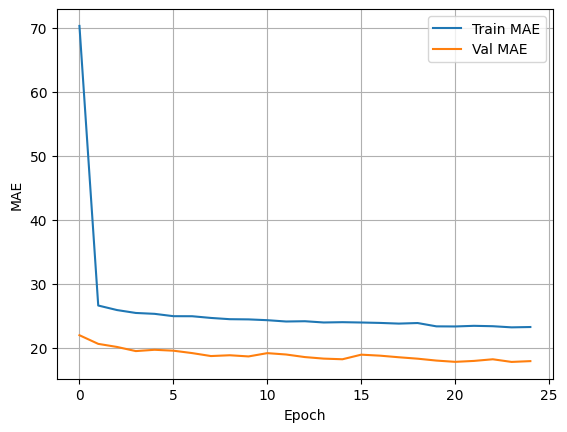

In [17]:
# Model
model = BoneAgeRegressor().to(device)
if COLAB:
    model = torch.compile(model)
print(f"modello inizializzato")

# Loss, ottimizzatore e scheduler
criterion = nn.L1Loss()
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, cooldown=1, min_lr=1e-8, verbose=True)

# Allenamento
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)

In [18]:
# Carica miglior modello e predici
model_loaded = BoneAgeRegressor().to(device)
if COLAB:
    model_loaded = torch.compile(model_loaded)
model_loaded.load_state_dict(torch.load("best_model.pth"))
predict_test(model_loaded, test_loader)

Loaded pretrained weights for efficientnet-b3


NameError: name 'test_loader' is not defined

In [19]:
if COLAB:
    submission_dataset = TestBoneAgeDataset(csv_path="/content/drive/MyDrive/test/test.csv",
                         image_dir="/content/drive/MyDrive/test",
                         transform=transform_validation_set)
else:
    submission_dataset = TestBoneAgeDataset(csv_path="test/test.csv",
                         image_dir="test/",
                         transform=transform_validation_set)
    
submission_loader = DataLoader(submission_dataset, batch_size=32)
model_loaded_1 = BoneAgeRegressor().to(device)
if COLAB:
    model_loaded_1 = torch.compile(model_loaded_1)

model_loaded_1.load_state_dict(torch.load("best_model.pth"))
predict_submission(model_loaded_1, submission_loader)

Loaded pretrained weights for efficientnet-b3
IMMAGINE: test/1.png
IMMAGINE: test/2.png
IMMAGINE: test/3.png
IMMAGINE: test/4.png
IMMAGINE: test/5.png
IMMAGINE: test/6.png
IMMAGINE: test/7.png
IMMAGINE: test/8.png
IMMAGINE: test/9.png
IMMAGINE: test/10.png
IMMAGINE: test/11.png
IMMAGINE: test/12.png
IMMAGINE: test/13.png
IMMAGINE: test/14.png
IMMAGINE: test/15.png
IMMAGINE: test/16.png
IMMAGINE: test/17.png
IMMAGINE: test/18.png
IMMAGINE: test/19.png
IMMAGINE: test/20.png
IMMAGINE: test/21.png
IMMAGINE: test/22.png
IMMAGINE: test/23.png
IMMAGINE: test/24.png
IMMAGINE: test/25.png
IMMAGINE: test/26.png
IMMAGINE: test/27.png
IMMAGINE: test/28.png
IMMAGINE: test/29.png
IMMAGINE: test/30.png
IMMAGINE: test/31.png
IMMAGINE: test/32.png
IMMAGINE: test/33.png
Predizioni salvate in: submission.csv


In [17]:
def train_model_full_training(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=30, save_path='best_model_full_training.pth', patience=7):
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    patience_counter = 0

    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0
        for images, sexes, ages, _ in train_loader:
            images, sexes, ages = images.to(device), sexes.to(device), ages.to(device).view(-1, 1)
            optimizer.zero_grad()
            loss = criterion(model(images, sexes), ages)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, sexes, ages, _ in val_loader:
                images, sexes, ages = images.to(device), sexes.to(device), ages.to(device).view(-1, 1)
                val_loss += criterion(model(images, sexes), ages).item() * images.size(0)
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        scheduler.step(val_loss)

        epoch_time = time.time() - epoch_start
        print(f"{'-'*100}")
        print(f"Epoch {epoch+1}, took: {epoch_time:.1f}s: Train MAE {train_loss:.2f} | Val MAE {val_loss:.2f}")
        for i, param_group in enumerate(optimizer.param_groups):
            print(f"LR gruppo {i}: {param_group['lr']}")

        if val_loss < best_val_loss:
            print("Validation loss improved. Model saved.")
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Trigger times: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("Early stopping")
                break

    # Plot
    plt.plot(train_losses, label="Train MAE")
    plt.plot(val_losses, label="Val MAE")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.grid()
    plt.show()

Loaded pretrained weights for efficientnet-b3
----------------------------------------------------------------------------------------------------
Epoch 1, took: 1153.0s: Train MAE 21.25 | Val MAE 15.50
LR gruppo 0: 1e-05
LR gruppo 1: 0.0005
Validation loss improved. Model saved.
----------------------------------------------------------------------------------------------------
Epoch 2, took: 1140.5s: Train MAE 19.83 | Val MAE 15.05
LR gruppo 0: 1e-05
LR gruppo 1: 0.0005
Validation loss improved. Model saved.
----------------------------------------------------------------------------------------------------
Epoch 3, took: 1161.0s: Train MAE 18.89 | Val MAE 14.57
LR gruppo 0: 1e-05
LR gruppo 1: 0.0005
Validation loss improved. Model saved.
----------------------------------------------------------------------------------------------------
Epoch 4, took: 1166.6s: Train MAE 18.52 | Val MAE 14.23
LR gruppo 0: 1e-05
LR gruppo 1: 0.0005
Validation loss improved. Model saved.
--------------

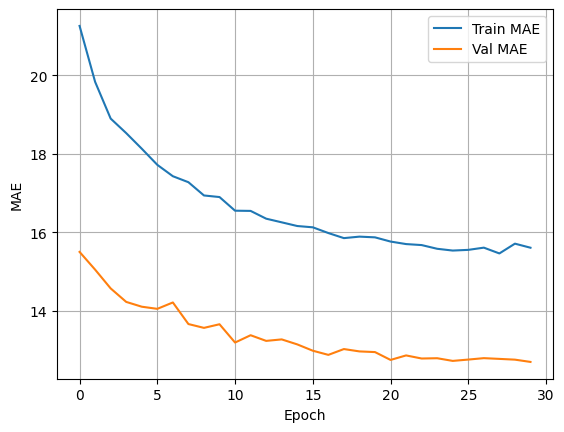

In [18]:
model_full_training = BoneAgeRegressor()
model_full_training.load_state_dict(torch.load('best_model.pth'))
model_full_training.to(device)

"""for param in model_full_training.backbone.parameters():
    param.requires_grad = True"""


# 1) Freeze dei primi 2 blocchi, unfreeze degli altri
#    (EfficientNet-B2 ha backbone._blocks di lunghezza 18)
for idx, block in enumerate(model_full_training.backbone._blocks):
    requires_grad = (idx >= 6)   # i blocchi con idx 0 e 1 restano congelati
    for param in block.parameters():
        param.requires_grad = requires_grad

# 2) Assicurati che la MLP finale sia sblocca­ta
for param in model_full_training.fc.parameters():
    param.requires_grad = True

criterion = nn.SmoothL1Loss(beta=1.0)
# Learning rates diversi
optimizer = torch.optim.AdamW([
    {'params': model_full_training.backbone.parameters(), 'lr': 1e-5, 'weight_decay': 0.0},
    {'params': model_full_training.fc.parameters(), 'lr': 5e-4, 'weight_decay': 1e-2}
])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, cooldown=1, min_lr=1e-8, verbose=True)
train_model_full_training(model_full_training, train_loader, val_loader, criterion, optimizer, scheduler)

In [ ]:
# Carica miglior modello e predici
model_full_training_loaded = BoneAgeRegressor().to(device)
if COLAB:
    model_full_training_loaded = torch.compile(model_loaded)
model_full_training_loaded.load_state_dict(torch.load("best_model_full_training.pth"))
predict_test(model_full_training_loaded, test_loader)

Loaded pretrained weights for efficientnet-b2
Predizioni salvate in: prediction_test.csv
Metriche di valutazione:
MAE:  9.25 mesi
RMSE: 12.07 mesi
R²:   0.919


In [20]:
if COLAB:
    submission_dataset = TestBoneAgeDataset(csv_path="/content/drive/MyDrive/test/test.csv",
                         image_dir="/content/drive/MyDrive/test",
                         transform=transform_validation_set)
else:
    submission_dataset = TestBoneAgeDataset(csv_path="test/test.csv",
                         image_dir="test/",
                         transform=transform_validation_set)

model_full_training_loaded = BoneAgeRegressor().to(device)
model_full_training_loaded.load_state_dict(torch.load("best_model_full_training.pth"))   
submission_loader = DataLoader(submission_dataset, batch_size=32)
predict_submission(model_full_training_loaded, submission_loader)

Loaded pretrained weights for efficientnet-b3
IMMAGINE: test/1.png
IMMAGINE: test/2.png
IMMAGINE: test/3.png
IMMAGINE: test/4.png
IMMAGINE: test/5.png
IMMAGINE: test/6.png
IMMAGINE: test/7.png
IMMAGINE: test/8.png
IMMAGINE: test/9.png
IMMAGINE: test/10.png
IMMAGINE: test/11.png
IMMAGINE: test/12.png
IMMAGINE: test/13.png
IMMAGINE: test/14.png
IMMAGINE: test/15.png
IMMAGINE: test/16.png
IMMAGINE: test/17.png
IMMAGINE: test/18.png
IMMAGINE: test/19.png
IMMAGINE: test/20.png
IMMAGINE: test/21.png
IMMAGINE: test/22.png
IMMAGINE: test/23.png
IMMAGINE: test/24.png
IMMAGINE: test/25.png
IMMAGINE: test/26.png
IMMAGINE: test/27.png
IMMAGINE: test/28.png
IMMAGINE: test/29.png
IMMAGINE: test/30.png
IMMAGINE: test/31.png
IMMAGINE: test/32.png
IMMAGINE: test/33.png
Predizioni salvate in: submission.csv


<class 'numpy.ndarray'>


/tmp/ipykernel_3750215/2051768073.py:102: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


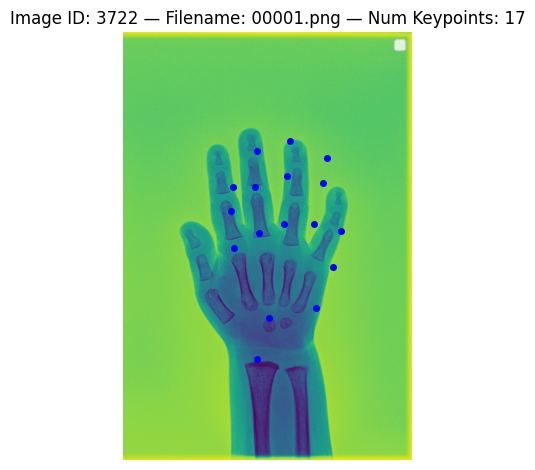

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

# === CONFIG ===
json_path = "./RHPE/RHPE_Annotations/RHPE_anatomical_ROIs_train.json"
image_base_path = "./RHPE/train/RHPE_train/"  # dove sono le immagini (./00001.png, ecc.)
image_filename_to_visualize = "00001.png"  # ← cambia questo per altre immagini
#padding = 100  # pixel per la box calcolata dai keypoint

# === CARICA JSON ===
with open(json_path, "r") as f:
    data = json.load(f)

# Trova immagine con questo nome
image_entry = next(img for img in data["images"] if img["file_name"] == image_filename_to_visualize)
image_width = image_entry["width"]
image_height = image_entry["height"]

# Trova la sua annotazione usando image_id
image_id = image_entry["id"]
annotation_entry = next(ann for ann in data["annotations"] if ann["image_id"] == image_id)

image_filename = image_entry["file_name"]
image_path = image_base_path + image_filename
image = np.array(Image.open(image_path))
#image_width = image.shape[1]

# === Estrai bbox COCO-style ===
x_min, y_min, w, h = annotation_entry["bbox"]
x_max = x_min + w
y_max = y_min + h

# === CREA BBOX INTERO FINO AL BORDO DELL'IMMAGINE ===
bbox_dataset = [
    (0, 0),
    (x_max, 0),
    (x_max, image_height),
    (0, image_height)
]

"""# === CREA BBOX SPECULARE (rispetto al centro della bbox) ===
bbox_dataset_simmetric = [
    (x_max, y_min),
    (x_max + (x_max - x_min), y_min),
    (x_max + (x_max - x_min), y_max),
    (x_max, y_max)
]"""

# === CREA BBOX SPECULARE (rispetto al centro della bbox) FINO AL BORDO DELL'IMMAGINE ===
bbox_dataset_simmetric = [
    (x_max, 0),
    (image_width, 0),
    (image_width, image_height),
    (x_max, image_height)
]

# === Estrai keypoints ===
keypoints_flat = annotation_entry["keypoints"]
keypoints = [(keypoints_flat[i], keypoints_flat[i+1]) for i in range(0, len(keypoints_flat), 3)]

x_min, y_min = bbox_dataset[0]
x_max, _ = bbox_dataset[1]
_, y_max = bbox_dataset[2]

width = x_max - x_min
height = y_max - y_min
print(type(image))
x_min, y_min = np.min(bbox_dataset, axis=0)
x_max, y_max = np.max(bbox_dataset, axis=0)

width = x_max - x_min
height = y_max - y_min

#cropped_image = TF.crop(image, top=int(y_min), left=int(x_min), height=int(height), width=int(width))
#cropped_image = image[int(y_min):int(y_max), int(x_min):int(x_max)]
###cropped_image = image[0:int(image_height), 0:int(x_max)]
cropped_image = image[0:int(image_height), int(x_max):int(image_width)]


# === Visualizza ===
fig, ax = plt.subplots()
ax.imshow(cropped_image)

"""# Box dataset (VIOLA)
polygon_dataset = patches.Polygon(bbox_dataset, closed=True, edgecolor='purple', linewidth=2, label="BBox Dataset", fill=False)
ax.add_patch(polygon_dataset)"""

"""# Box speculare (ROSSO)
polygon_mirror = patches.Polygon(bbox_dataset_simmetric, closed=True, edgecolor='red', linestyle='--', linewidth=2, label="Specular BBox", fill=False)
ax.add_patch(polygon_mirror)"""

# Keypoints (BLU)
for (x, y) in keypoints:
    ax.plot(x, y, 'bo', markersize=4)

# Info testuale
num_keypoints = annotation_entry["num_keypoints"]
plt.title(f"Image ID: {image_id} — Filename: {image_filename_to_visualize} — Num Keypoints: {num_keypoints}")
plt.legend(loc='upper right')
plt.axis('off')
plt.tight_layout()
plt.show()
